# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pprint import pprint

from utils.process_utils import merge_kernel_time, get_fc_flops

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
pd.set_option('display.max_rows', 80)
%matplotlib inline

# Load + Save Data

In [2]:
small_df = "small.csv"
full_df = "combined.csv"

path = f"../data/linear/{small_df}"
df = pd.read_csv(path)
print(df.shape)
df.head()

(230682, 72)


,Params,Inputs,Precision,Bias,Input Size,Output Size,Kernel Name,Context,Stream,Block Size,...,SM Busy (%),SM Frequency (cycle/usecond),Shared Memory Configuration Size (Kbyte),Static Shared Memory Per Block (byte/block),Theoretical Active Warps per SM (warp),Theoretical Occupancy (%),Threads (thread),Warp Cycles Per Executed Instruction (cycle),Warp Cycles Per Issued Instruction (cycle),Latency (ms)
0,960.161.0.768.96,960,161,0,768,96,ampere_bf16_s16816gemm_bf16_64x64_sliced1x2_ld...,1,7,"(128, 1, 1)",...,31.54,1240.0,102.40,49150.0,0.0,0.00,3840.0,4.83,4.80,0.098304
1,216.32.1.128.36,216,32,1,128,36,ampere_sgemm_32x32_sliced1x4_tn,1,7,"(128, 1, 1)",...,22.44,1220.0,135.17,32770.0,16.0,25.00,1792.0,4.97,4.94,0.100352
2,76.162.0.100.352,76,162,0,100,352,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,7,"(128, 1, 1)",...,16.84,1130.0,102.40,0.0,20.0,31.25,6144.0,6.26,6.01,0.098304
3,100.162.1.208.2,100,162,1,208,2,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,7,"(128, 1, 1)",...,19.16,1220.0,102.40,0.0,20.0,31.25,1536.0,5.32,5.11,0.101888
4,2.162.0.20.272,2,162,0,20,272,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,7,"(128, 1, 1)",...,17.63,1200.0,167.94,0.0,16.0,25.00,2048.0,5.61,5.38,0.096256


## Save small sample for analysis

In [3]:
SAMPLE_SMALL_DF = False
if SAMPLE_SMALL_DF:
    df2 = df.sample(frac=0.1)
    df2.head()
    df2.to_csv(f"../data/linear/small.csv", index=False)
    df = df2

# EDA: Mainly Features Accessible At Inference Time

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230682 entries, 0 to 230681
Data columns (total 72 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Params                                           230682 non-null  object 
 1   Inputs                                           230682 non-null  int64  
 2   Precision                                        230682 non-null  int64  
 3   Bias                                             230682 non-null  int64  
 4   Input Size                                       230682 non-null  int64  
 5   Output Size                                      230682 non-null  int64  
 6   Kernel Name                                      230682 non-null  object 
 7   Context                                          230682 non-null  int64  
 8   Stream                                           230682 non-null  int64  
 9   Block Size     

## Create Features and Load Checkpoint

In [5]:
SAVE_DF = False
path = "../data/linear/merged_kernel_times.csv"

if SAVE_DF:
    df['kFLOPs'] = df.apply(get_fc_flops, axis=1)
    print("Created kFlops")
    df = merge_kernel_time(df)
    # TODO: take care of this earlier.
    df['Precision'] = df['Precision'].astype(float).astype(int).astype(str)
    df.to_csv(path, index=False)
else:
    df = pd.read_csv(path)

In [6]:
df.head()

,Params,Inputs,Bias,Input Size,Output Size,Context,Stream,Device,CC,Avg. Active Threads Per Warp,...,Theoretical Active Warps per SM (warp),Theoretical Occupancy (%),Threads (thread),Warp Cycles Per Executed Instruction (cycle),Warp Cycles Per Issued Instruction (cycle),Latency (ms),kFLOPs,Duration (usecond),Kernels Launched,Precision
0,1.161.0.1.1,1.0,0.0,1.0,1.0,1.0,7.0,0.0,8.0,14.22,...,12.0,18.75,128.0,20.52,17.92,0.109056,0.003,4.51,1.0,161
1,1.161.0.1.120,1.0,0.0,1.0,120.0,1.0,7.0,0.0,8.0,30.27,...,64.0,100.00,1024.0,31.65,26.20,0.109568,0.360,3.84,1.0,161
2,1.161.0.1.20,1.0,0.0,1.0,20.0,1.0,7.0,0.0,8.0,25.28,...,64.0,100.00,256.0,35.77,29.62,0.109056,0.060,3.78,1.0,161
3,1.161.0.1.240,1.0,0.0,1.0,240.0,1.0,7.0,0.0,8.0,30.28,...,64.0,100.00,2048.0,34.27,28.37,0.107008,0.720,3.81,1.0,161
4,1.161.0.1.4,1.0,0.0,1.0,4.0,1.0,7.0,0.0,8.0,17.36,...,64.0,100.00,256.0,35.53,29.43,0.108032,0.012,3.81,1.0,161


## Train-Test Split

In [7]:
categorical = ["Precision"]
numeric = list(sorted(["Inputs", "Bias", "Input Size", "Output Size", "kFLOPs", "Kernels Launched"])) # TODO: Kernels Launched not available

X_cols = list(sorted(categorical + numeric))
y_cols = ['Latency (ms)', 'Duration (usecond)']

X, y = df[X_cols], df[y_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
train_df = pd.concat([X_train, y_train], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159522 entries, 47221 to 199340
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Bias                159522 non-null  float64
 1   Input Size          159522 non-null  float64
 2   Inputs              159522 non-null  float64
 3   Kernels Launched    159522 non-null  float64
 4   Output Size         159522 non-null  float64
 5   Precision           159522 non-null  int64  
 6   kFLOPs              159522 non-null  float64
 7   Latency (ms)        159522 non-null  float64
 8   Duration (usecond)  159522 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 12.2 MB


array([[<AxesSubplot:title={'center':'Bias'}>,
        <AxesSubplot:title={'center':'Input Size'}>,
        <AxesSubplot:title={'center':'Inputs'}>],
       [<AxesSubplot:title={'center':'Kernels Launched'}>,
        <AxesSubplot:title={'center':'Output Size'}>,
        <AxesSubplot:title={'center':'Precision'}>],
       [<AxesSubplot:title={'center':'kFLOPs'}>,
        <AxesSubplot:title={'center':'Latency (ms)'}>,
        <AxesSubplot:title={'center':'Duration (usecond)'}>]],
      dtype=object)

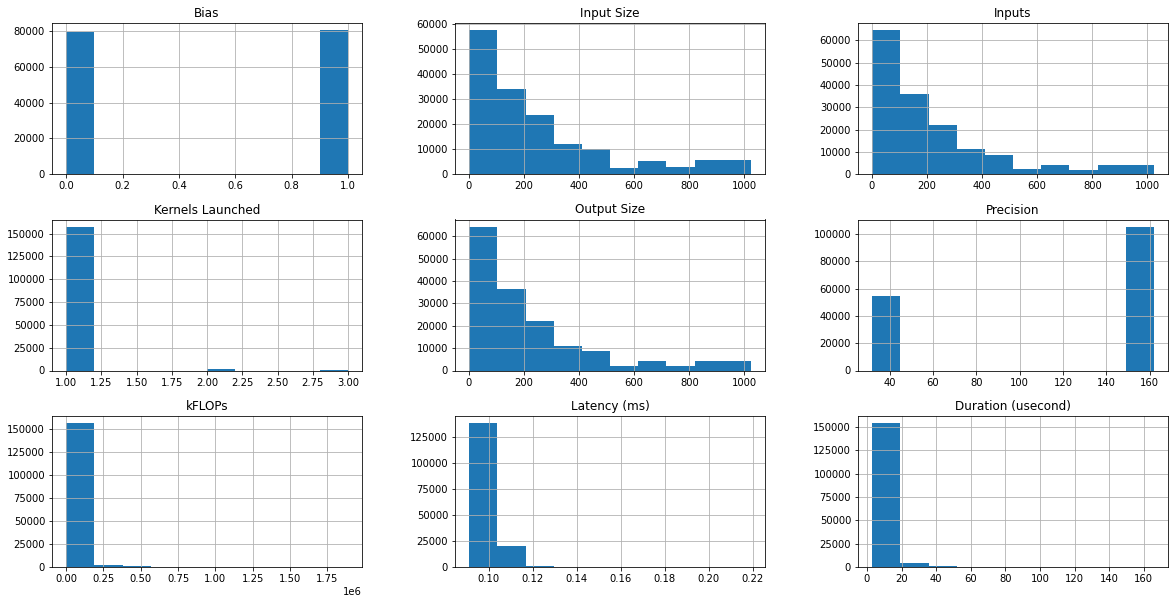

In [8]:
train_df.hist(figsize=(20, 10))

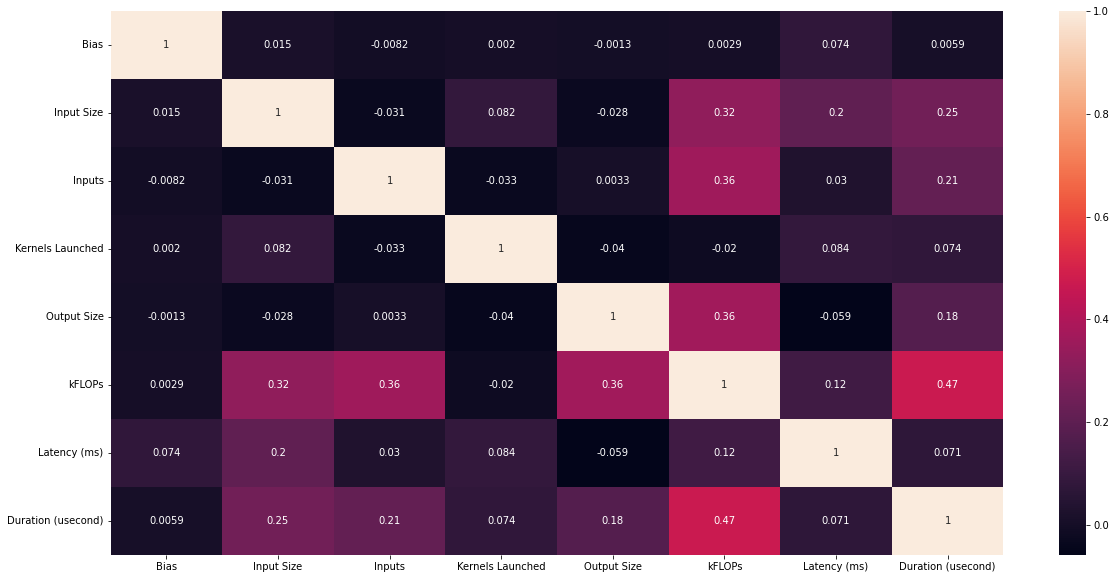

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(train_df[numeric + y_cols].corr(), annot=True)
plt.show()

## TODO: separate into two categories.

## Scatter Plots

In [10]:
def plot_scatter(df: pd.DataFrame, y: str):
    for col in df:
        if col != y:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=df[col], y=df[y])
            plt.show()

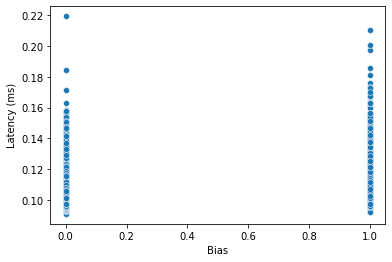

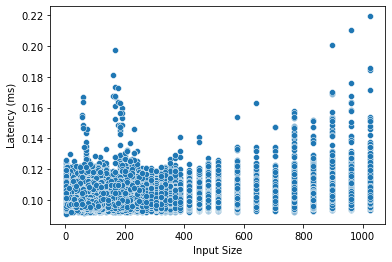

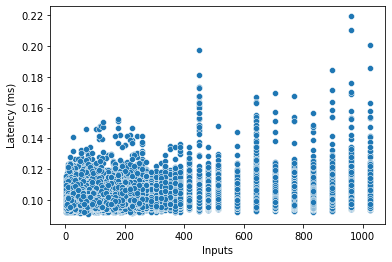

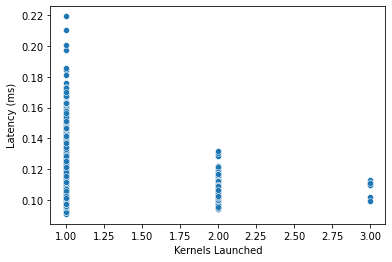

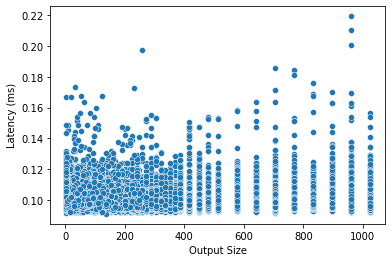

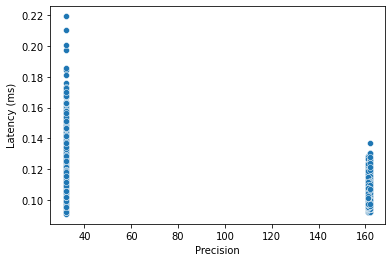

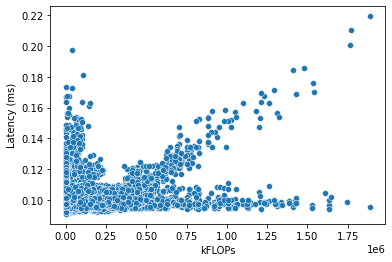

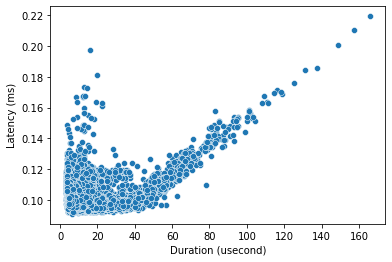

In [11]:
plot_scatter(train_df, "Latency (ms)")

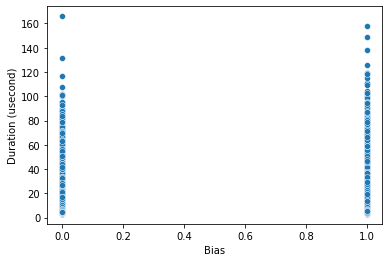

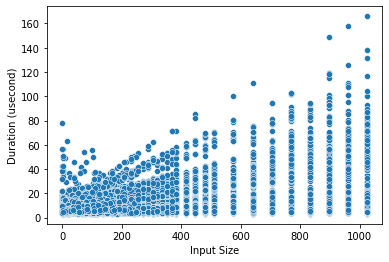

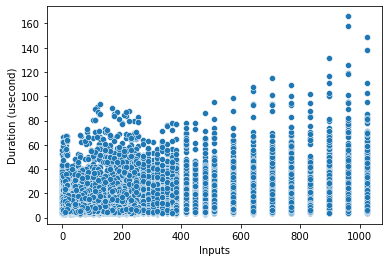

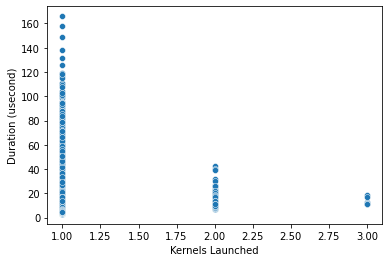

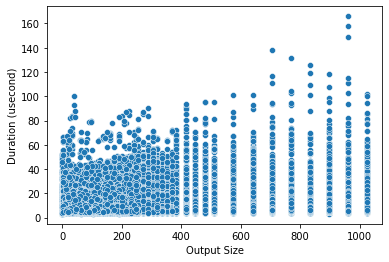

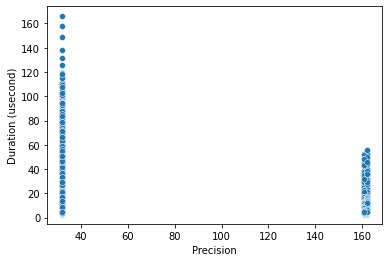

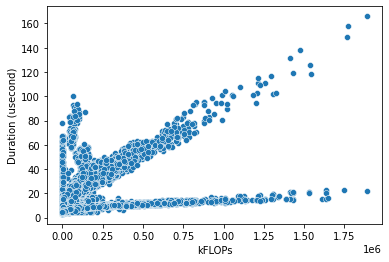

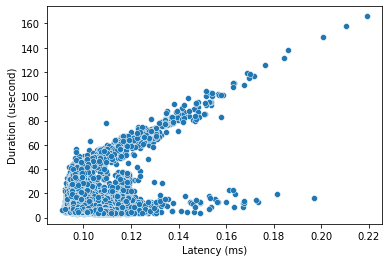

In [12]:
plot_scatter(train_df, "Duration (usecond)")

## Scatter Plots with Hues

In [30]:
def plot_scatter_hues(df: pd.DataFrame, y: str, hue: str, palette: str = "bright") -> None:
    assert(y in df)
    assert(hue in df)
    for col in df:
        if col != y and col != hue:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=df[col], y=df[y], hue=df[hue], palette=palette, alpha=0.3)
            plt.show()

### Precision - Most Useful

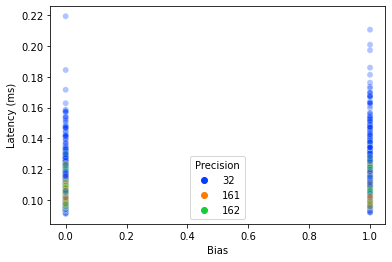

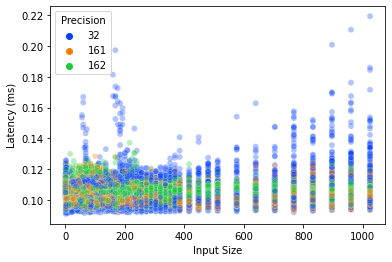

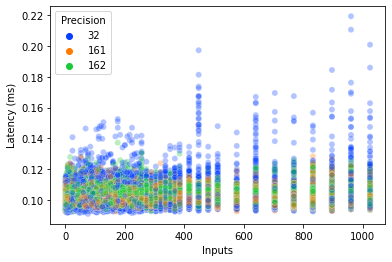

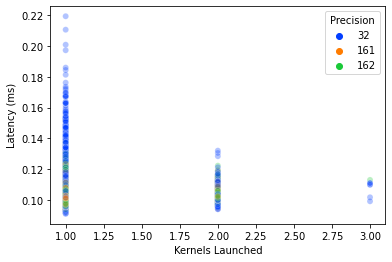

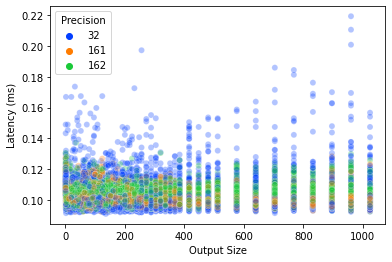

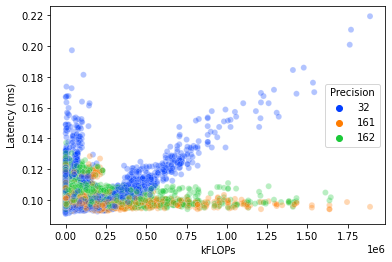

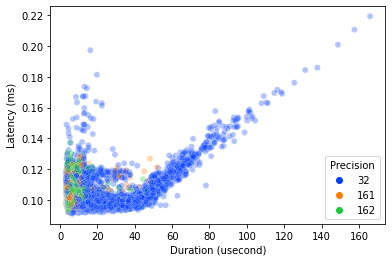

In [31]:
plot_scatter_hues(train_df, "Latency (ms)", "Precision")

In [32]:
# plot_scatter_hues(train_df, "Duration (usecond)", "Precision")

### Kernels Launched - Not Useful

Not that many kernels with > 1 kernels launched

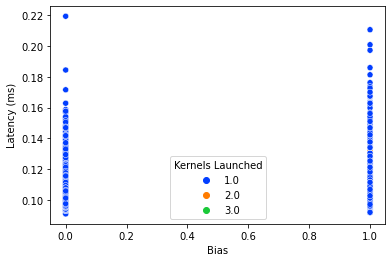

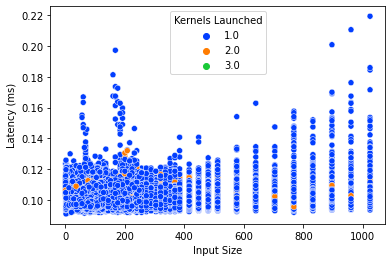

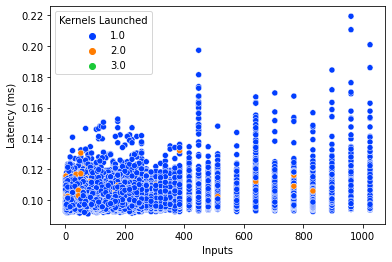

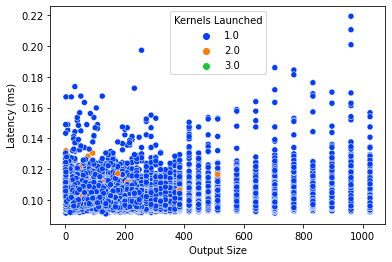

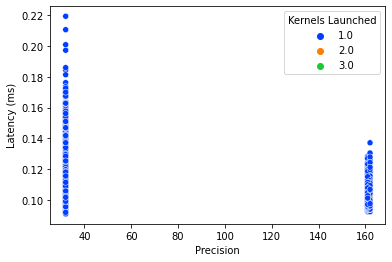

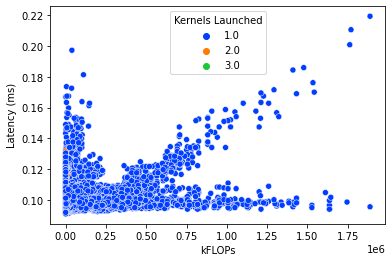

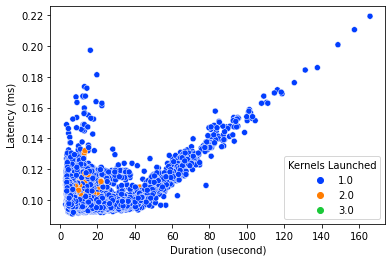

In [16]:
plot_scatter_hues(train_df, "Latency (ms)", "Kernels Launched")

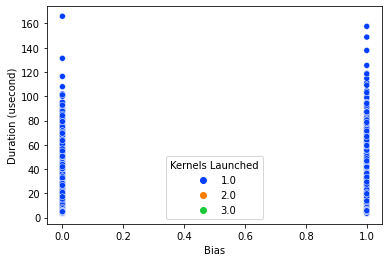

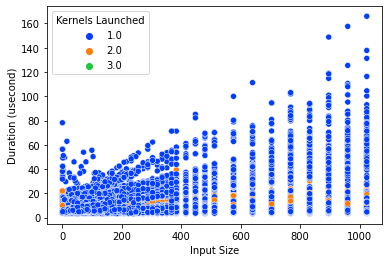

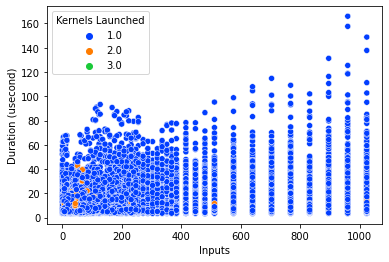

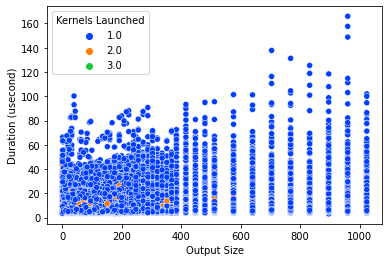

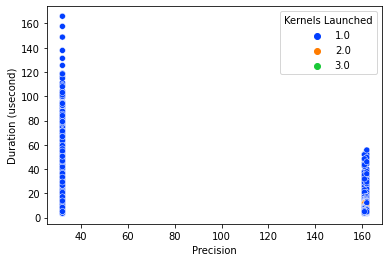

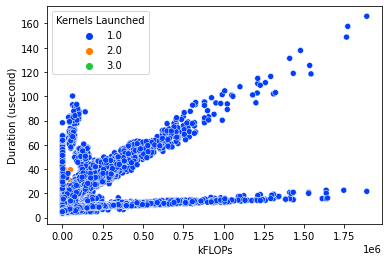

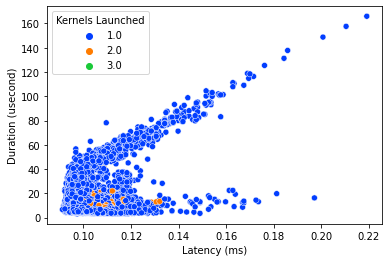

In [28]:
plot_scatter_hues(train_df, "Duration (usecond)", "Kernels Launched")

### Bias - Not Useful

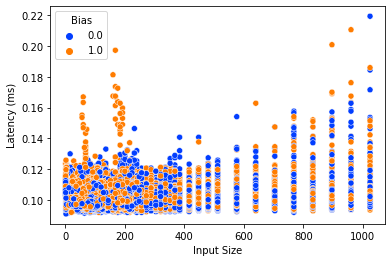

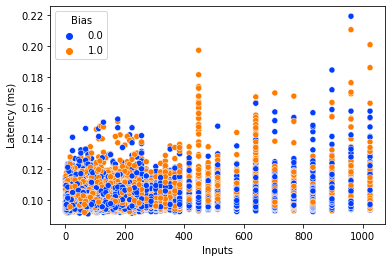

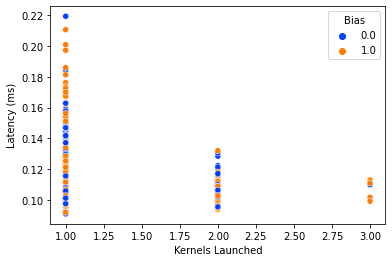

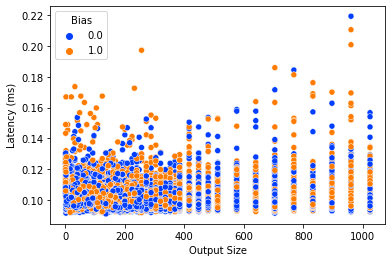

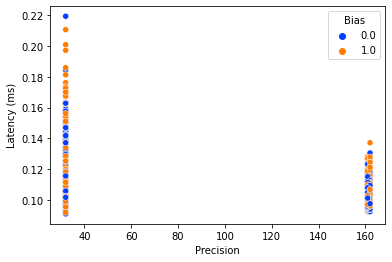

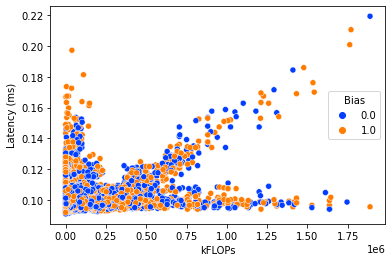

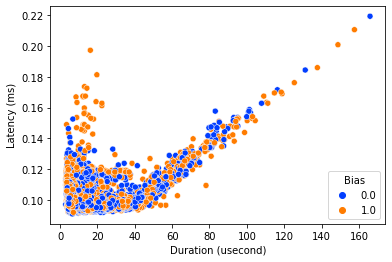

In [17]:
plot_scatter_hues(train_df, "Latency (ms)", "Bias")

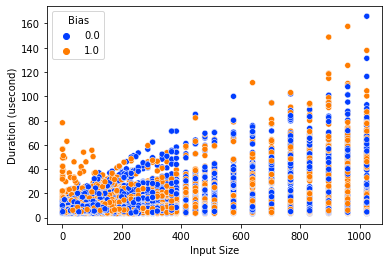

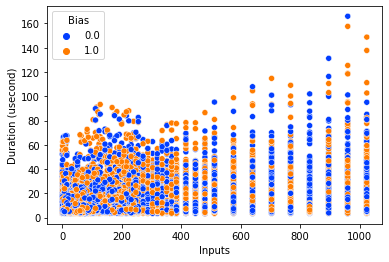

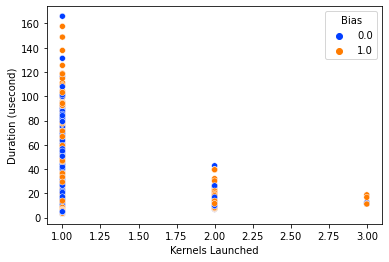

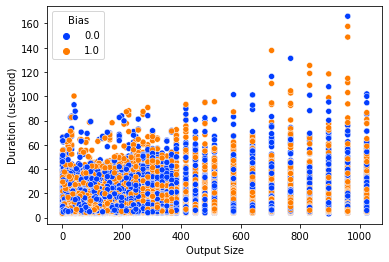

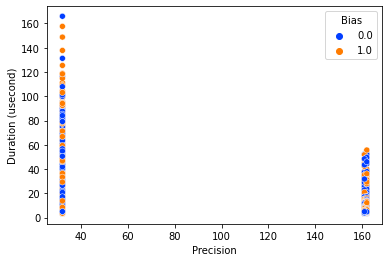

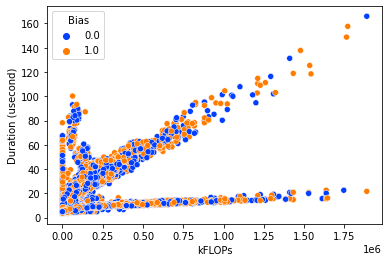

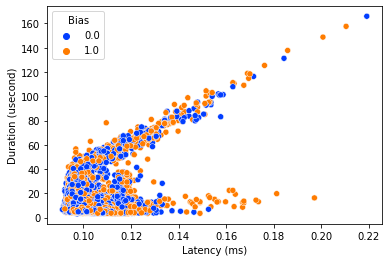

In [18]:
plot_scatter_hues(train_df, "Duration (usecond)", "Bias")

### What's up with float 32?

In [35]:
train_df_32 = train_df[train_df["Precision"] == 32]
train_df_32.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54243 entries, 112537 to 152315
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Bias                54243 non-null  float64
 1   Input Size          54243 non-null  float64
 2   Inputs              54243 non-null  float64
 3   Kernels Launched    54243 non-null  float64
 4   Output Size         54243 non-null  float64
 5   Precision           54243 non-null  int64  
 6   kFLOPs              54243 non-null  float64
 7   Latency (ms)        54243 non-null  float64
 8   Duration (usecond)  54243 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 4.1 MB


#### Scatter Plots

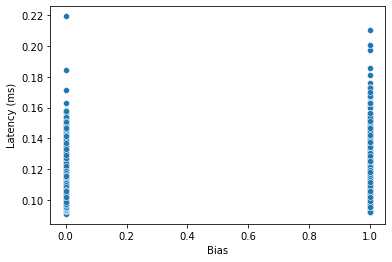

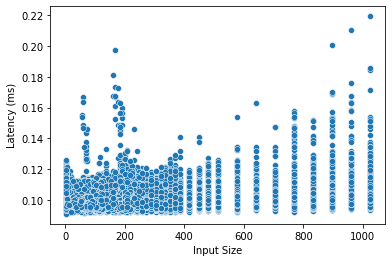

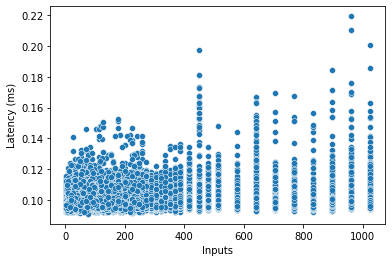

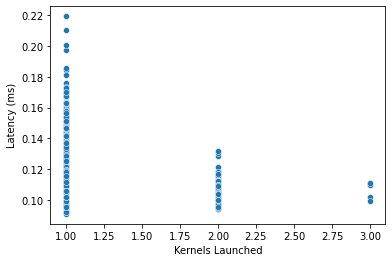

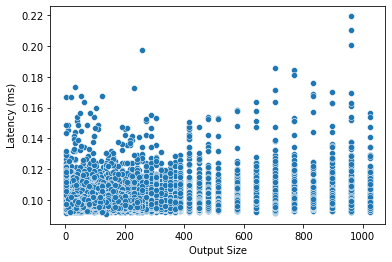

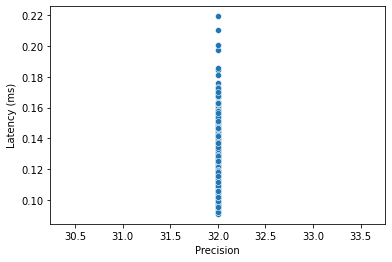

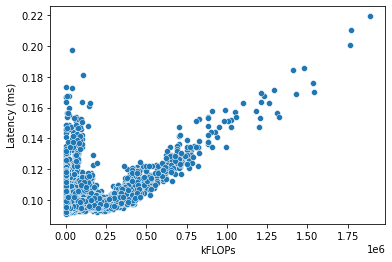

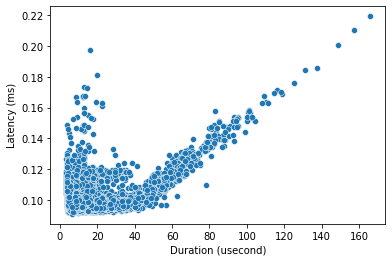

In [36]:
plot_scatter(train_df_32, "Latency (ms)")

In [29]:
# plot_scatter(train_df_32, "Duration (usecond)")

#### Other

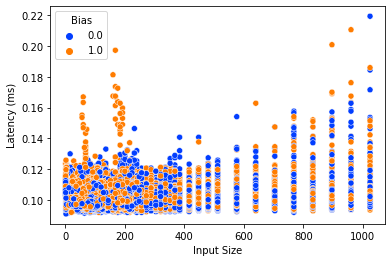

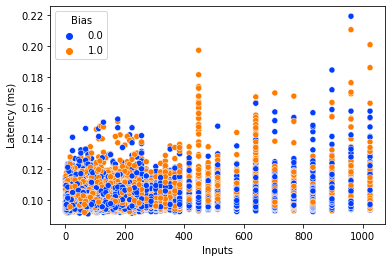

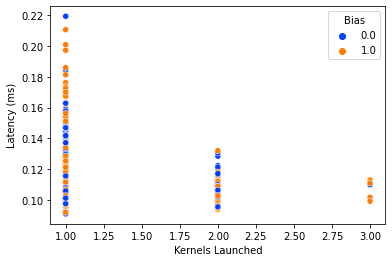

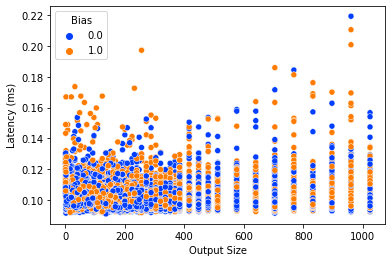

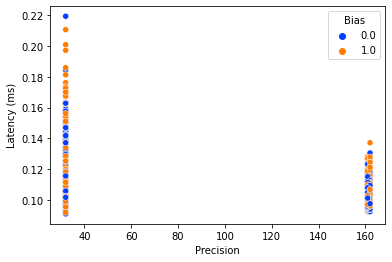

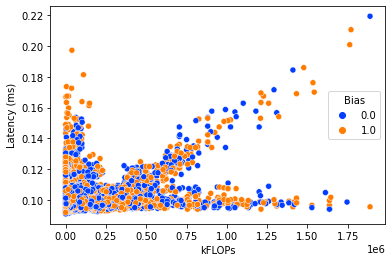

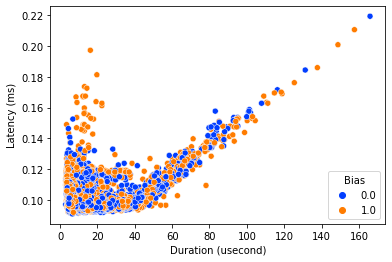

In [49]:
plot_scatter_hues(train_df_32, "Latency (ms)", "Bias")

In [58]:
# df[df['kFLOPs < ']]
train_df_32_small = train_df_32[train_df_32["kFLOPs"] < ]
train_df_32_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54243 entries, 112537 to 152315
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Bias                54243 non-null  float64
 1   Input Size          54243 non-null  float64
 2   Inputs              54243 non-null  float64
 3   Kernels Launched    54243 non-null  float64
 4   Output Size         54243 non-null  float64
 5   Precision           54243 non-null  int64  
 6   kFLOPs              54243 non-null  float64
 7   Latency (ms)        54243 non-null  float64
 8   Duration (usecond)  54243 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 4.1 MB


### Bottom Line?

In [71]:
train_df_small = train_df[train_df['Latency (ms)'] < 0.12]
train_df_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159068 entries, 47221 to 199340
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Bias                159068 non-null  float64
 1   Input Size          159068 non-null  float64
 2   Inputs              159068 non-null  float64
 3   Kernels Launched    159068 non-null  float64
 4   Output Size         159068 non-null  float64
 5   Precision           159068 non-null  int64  
 6   kFLOPs              159068 non-null  float64
 7   Latency (ms)        159068 non-null  float64
 8   Duration (usecond)  159068 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 12.1 MB


## Linear Regression

In [74]:
train_df = pd.get_dummies(train_df, columns=['Precision'], drop_first=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159522 entries, 47221 to 199340
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Bias                159522 non-null  float64
 1   Input Size          159522 non-null  float64
 2   Inputs              159522 non-null  float64
 3   Kernels Launched    159522 non-null  float64
 4   Output Size         159522 non-null  float64
 5   kFLOPs              159522 non-null  float64
 6   Latency (ms)        159522 non-null  float64
 7   Duration (usecond)  159522 non-null  float64
 8   Precision_162       159522 non-null  bool   
 9   Precision_32        159522 non-null  bool   
dtypes: bool(2), float64(8)
memory usage: 11.3 MB


In [51]:
# scaler = StandardScaler()
# scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train[numeric]), columns=numeric, index=X_train.index)

In [85]:
print(y_train.dtypes)
print(X_train.dtypes)

Latency (ms)          float64
Duration (usecond)    float64
dtype: object
const               float64
Bias                float64
Input Size          float64
Inputs              float64
Kernels Launched    float64
Output Size         float64
Precision            object
kFLOPs              float64
dtype: object


In [86]:
X_train = pd.get_dummies(X_train, columns=['Precision'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Precision'], drop_first=True)

In [92]:
X_train['Precision_162'] = X_train['Precision_162'].astype(int)
X_train['Precision_32'] = X_train['Precision_32'].astype(int)

In [94]:
print(X_train.info())
# print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 159522 entries, 47221 to 199340
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   const             159522 non-null  float64
 1   Bias              159522 non-null  float64
 2   Input Size        159522 non-null  float64
 3   Inputs            159522 non-null  float64
 4   Kernels Launched  159522 non-null  float64
 5   Output Size       159522 non-null  float64
 6   kFLOPs            159522 non-null  float64
 7   Precision_162     159522 non-null  int64  
 8   Precision_32      159522 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 12.2 MB
None


In [95]:
# scaler = StandardScaler()
# X_train = sm.add_constant(scaler.fit_transform(X_train))
# X_test = sm.add_constant(scaler.transform(X_test))

X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)
for col in y_train:
    print(col)
    model = sm.OLS(y_train[col], X_train).fit()
    print(model.summary())

Latency (ms)
                            OLS Regression Results                            
Dep. Variable:           Latency (ms)   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2066.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:39:17   Log-Likelihood:             6.5812e+05
No. Observations:              159522   AIC:                        -1.316e+06
Df Residuals:                  159513   BIC:                        -1.316e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0964

Latency (ms) ------------------------------------------------v
                            OLS Regression Results                            
Dep. Variable:           Latency (ms)   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2066.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:42:04   Log-Likelihood:             6.5812e+05
No. Observations:              159522   AIC:                        -1.316e+06
Df Residuals:                  159513   BIC:                        -1.316e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

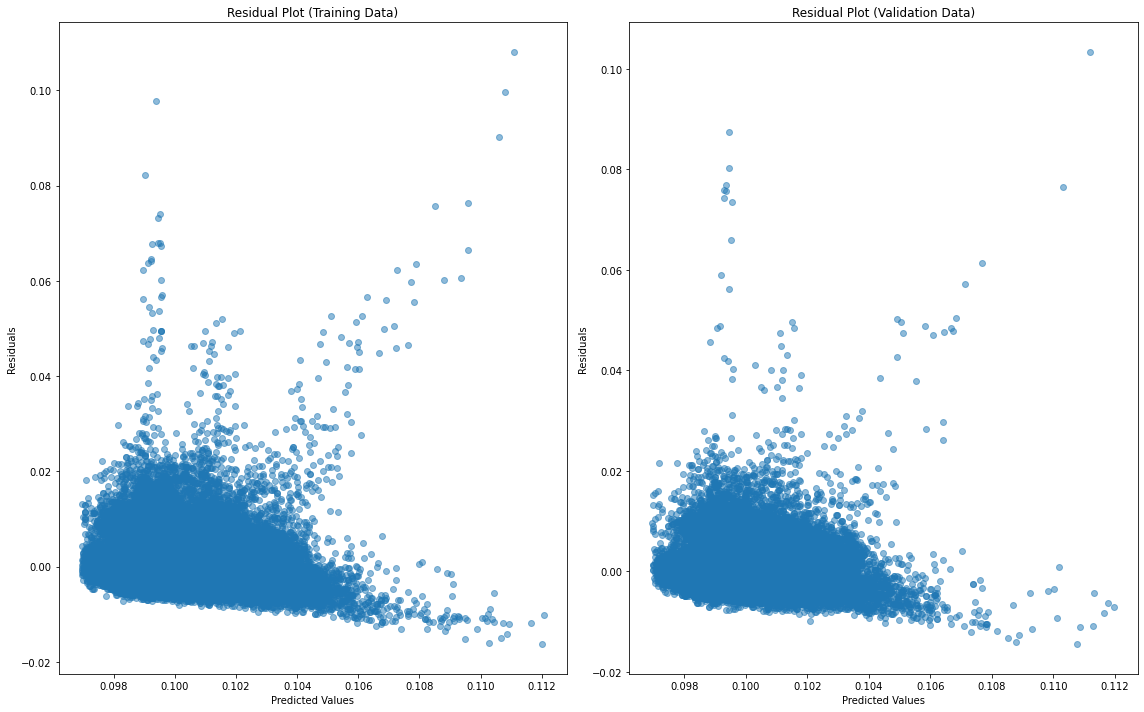

Duration (usecond) ------------------------------------------------v
                            OLS Regression Results                            
Dep. Variable:     Duration (usecond)   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                 1.540e+04
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:42:04   Log-Likelihood:            -4.5927e+05
No. Observations:              159522   AIC:                         9.186e+05
Df Residuals:                  159513   BIC:                         9.186e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

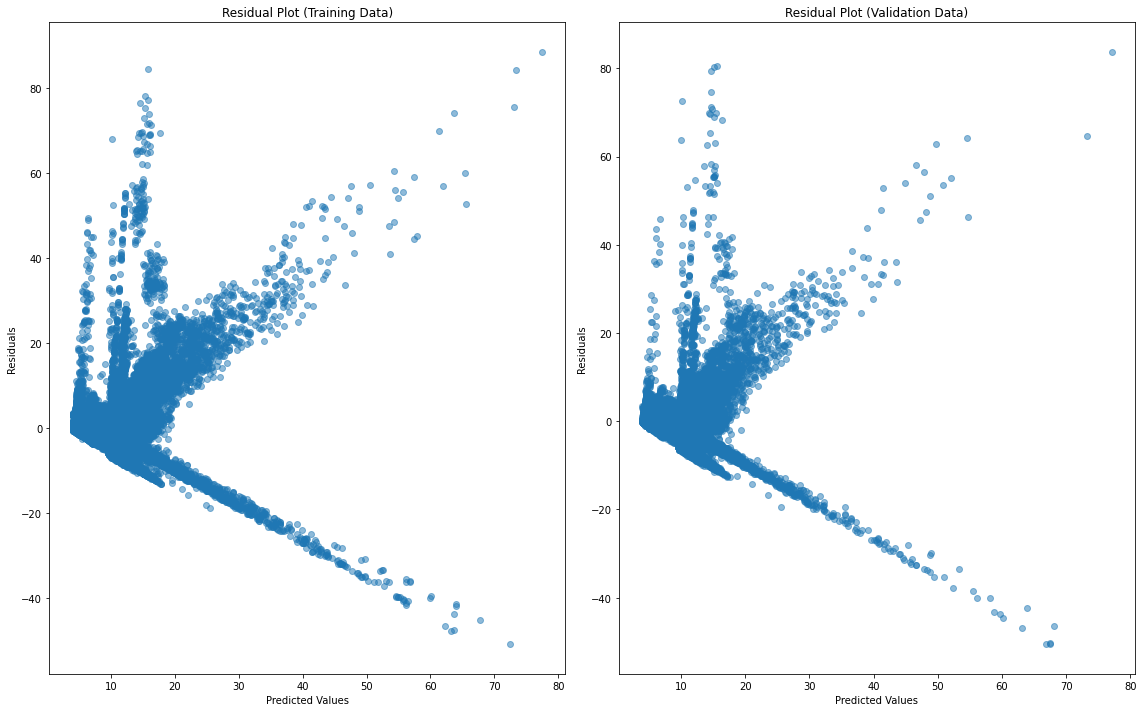

In [97]:
for col in y_cols:
    print(col, "------------------------------------------------v")
    model = sm.OLS(y_train[col], X_train).fit()
    print(model.summary())

    y_pred = model.predict(X_train)
    y_pred_val = model.predict(X_test)

    print('Train r2:', r2_score(y_train[col], y_pred))
    print('Train MSE:', mean_squared_error(y_train[col], y_pred))

    print('Validation r2:', r2_score(y_test[col], y_pred_val))
    print('Validation MSE:', mean_squared_error(y_test[col], y_pred_val))

    residuals_train = y_train[col] - y_pred
    residuals_val = y_test[col] - y_pred_val

    # Plot residual graph for training data
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals_train, alpha=0.5)
    plt.title('Residual Plot (Training Data)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')

    # Plot residual graph for validation data
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred_val, residuals_val, alpha=0.5)
    plt.title('Residual Plot (Validation Data)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

# EDA: All Collected Features

In [ ]:
to_drop = {"Params", "Kernel Name", "Context", "Stream", "Block Size", "Grid Size", "Device", "CC", "Function Cache Configuration"} # Kernels Launched
y_cols = {"Latency (ms)", "Duration (usecond)"}
columns = set(df.columns)

X_cols = sorted(columns - to_drop) # - y_cols
# X_cols = sorted(["Inputs", "Input Size", "Output Size", "Bias", "kFLOPs"])

# for col in to_drop:
#     print(df[col].unique())

# for col in X_cols:
#     print(df[col][0])

In [11]:
X, y = df[list(X_cols)], df['Latency (ms)'] # df['Duration (usecond)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0) # TODO: change!
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_train, y_train], axis=1)

In [23]:
# train_df.head()
# X_train.head()
# y_train.head()

In [24]:
# train_df.info()
# X_train.info()

In [25]:
# train_df.describe()

0.09730767403756466


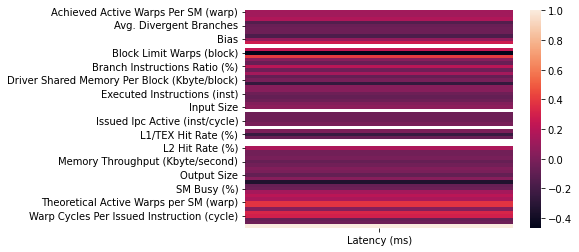

In [12]:
sns.heatmap(train_df.corr()[['Latency (ms)']])

print(df['Duration (usecond)'].corr(df['Latency (ms)']))

# for col in X_cols:
#     print(f"{col}: {df[col].corr(df['Latency (ms)'])}")

In [50]:
# train_df.hist(figsize=(16, 8))

In [13]:
# Example using StandardScaler
scaler = StandardScaler()
X_train = sm.add_constant(scaler.fit_transform(X_train))
X_test = sm.add_constant(scaler.transform(X_test))
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Latency (ms)   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     274.4
Date:                Sat, 23 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:16:16   Log-Likelihood:                 69672.
No. Observations:               14700   AIC:                        -1.392e+05
Df Residuals:                   14644   BIC:                        -1.388e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0974   1.75e-05   5572.357      0.0

Train r2: 0.5075319982430522
Train MSE: 4.4744796622485875e-06
Validation r2: 0.5009960259184534
Validation MSE: 4.678391632799515e-06
(14700,) (14700,)


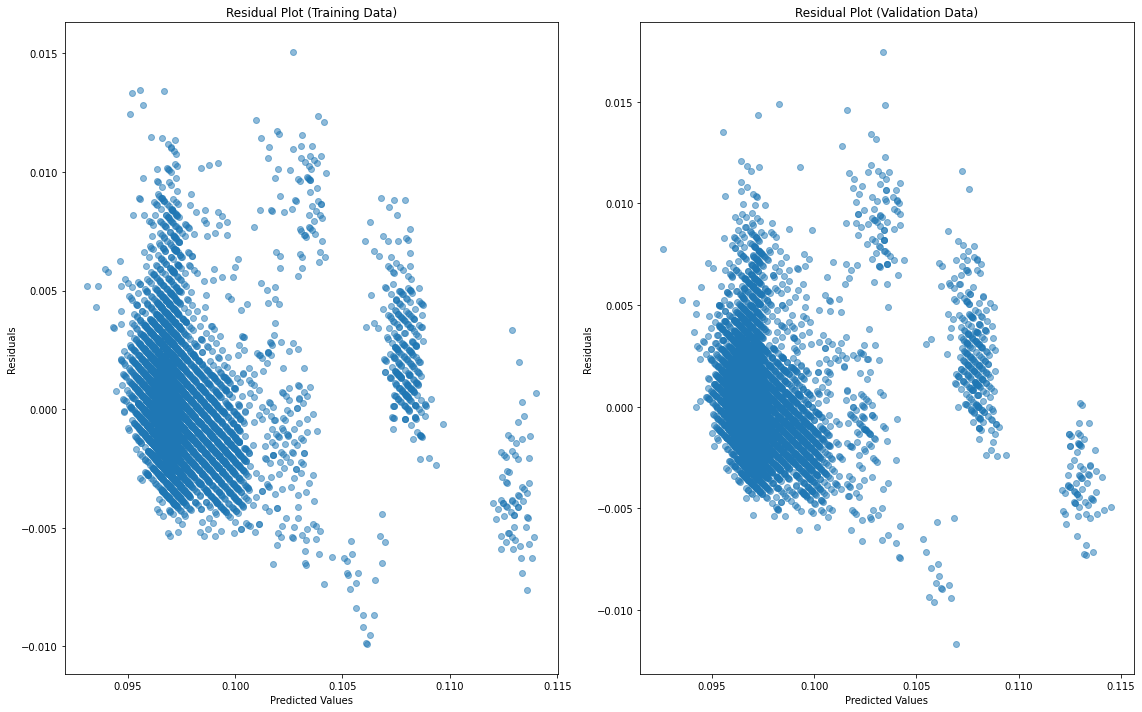

In [15]:
y_pred = model.predict(X_train)
y_pred_val = model.predict(X_test)

print('Train r2:', r2_score(y_train, y_pred))
print('Train MSE:', mean_squared_error(y_train, y_pred))

print('Validation r2:', r2_score(y_test, y_pred_val))
print('Validation MSE:', mean_squared_error(y_test, y_pred_val))

residuals_train = y_train - y_pred
residuals_val = y_test - y_pred_val

print(y_pred.shape, residuals_train.shape)

# Plot residual graph for training data
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals_train, alpha=0.5)
plt.title('Residual Plot (Training Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Plot residual graph for validation data
plt.subplot(1, 2, 2)
plt.scatter(y_pred_val, residuals_val, alpha=0.5)
plt.title('Residual Plot (Validation Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Latency')

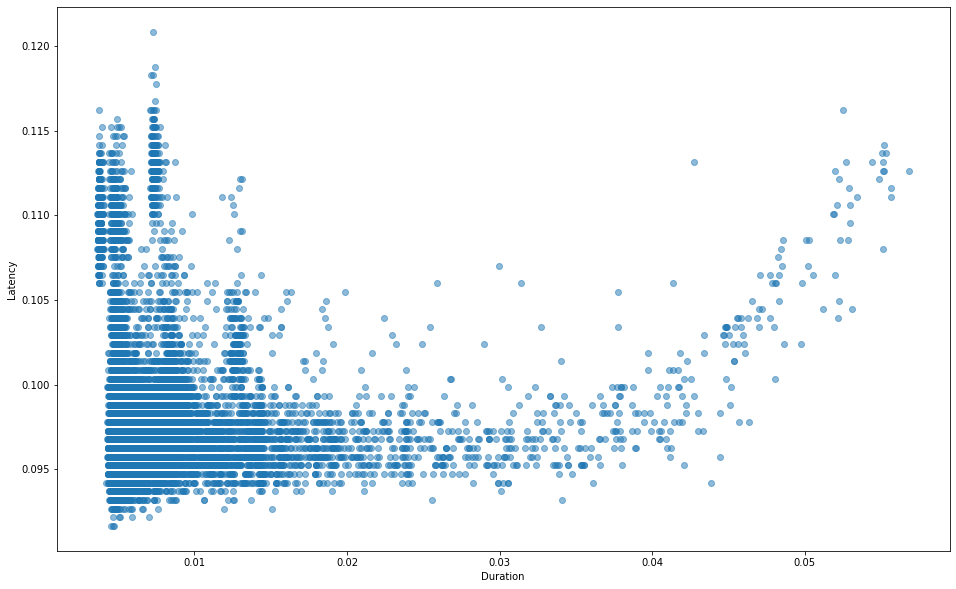

In [17]:
latency, runtime = df['Latency (ms)'], df['Duration (usecond)'] / 1000.0
plt.figure(figsize=(16, 10))
plt.scatter(runtime, latency, alpha=0.5)
plt.xlabel('Duration')
plt.ylabel('Latency')

Text(0, 0.5, 'Latency')

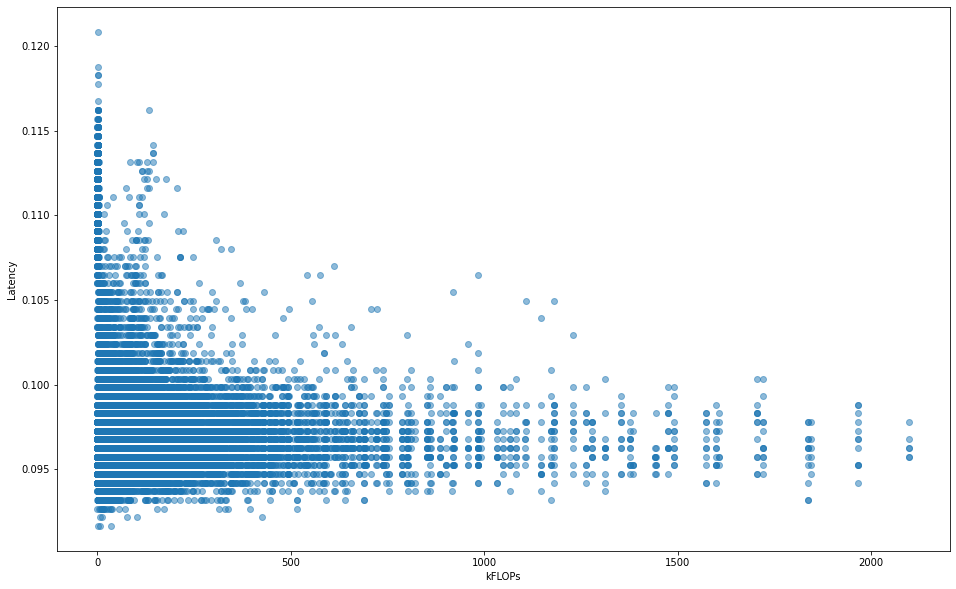

In [14]:
latency, flops = df['Latency (ms)'], df['kFLOPs']
plt.figure(figsize=(16, 10))
plt.scatter(flops, latency, alpha=0.5)
plt.xlabel('kFLOPs')
plt.ylabel('Latency')

Text(0, 0.5, 'Duration')

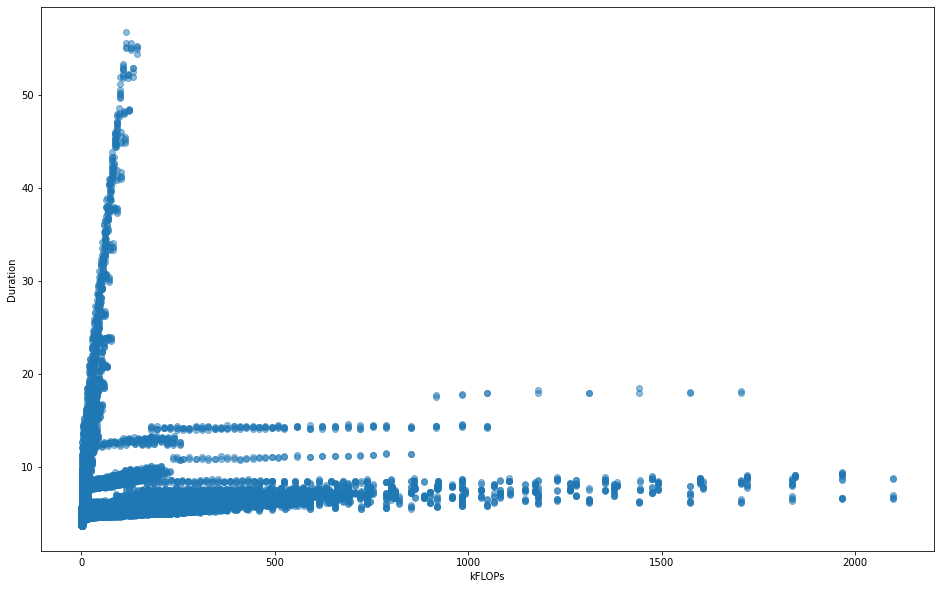

In [15]:
runtime, flops = df['Duration (usecond)'], df['kFLOPs']
plt.figure(figsize=(16, 10))
plt.scatter(flops, runtime, alpha=0.5)
plt.xlabel('kFLOPs')
plt.ylabel('Duration')

In [82]:
print(df['Latency (ms)'].max())

0.2355200052261352


# Random Forest

In [114]:
def evaluate_model(model, X_train_encoded, y_train, X_test_encoded, y_test):
    y_train_pred  = model.predict(X_train_encoded)
    y_test_pred = model.predict(X_test_encoded)

    """
    TODO: wrap this into a function...
    """
    print('Train r2:', r2_score(y_train, y_train_pred))
    print('Train MSE:', mean_squared_error(y_train, y_train_pred))

    print('Validation r2:', r2_score(y_test, y_test_pred))
    print('Validation MSE:', mean_squared_error(y_test, y_test_pred))

    residuals_train = y_train - y_train_pred
    residuals_val = y_test - y_test_pred

    # Plot residual graph for training data
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.title('Residual Plot (Training Data)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')

    # Plot residual graph for validation data
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred, residuals_val, alpha=0.5)
    plt.title('Residual Plot (Validation Data)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()


## Imports

In [110]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

## Inference Features

In [75]:
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227889 entries, 0 to 227888
Data columns (total 72 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Unnamed: 0.1                                     227889 non-null  int64  
 1   Unnamed: 0                                       227889 non-null  int64  
 2   Params                                           227889 non-null  object 
 3   Inputs                                           227889 non-null  float64
 4   Bias                                             227889 non-null  float64
 5   Input Size                                       227889 non-null  float64
 6   Output Size                                      227889 non-null  float64
 7   Context                                          227889 non-null  float64
 8   Stream                                           227889 non-null  float64
 9   Device         

In [83]:
categorical = ["Precision"]
numeric = list(sorted(["Inputs", "Bias", "Input Size", "Output Size", "kFLOPs"]))

X_cols = list(sorted(categorical + numeric))
y_cols = ["Latency (ms)", "Duration (usecond)"]

X, y = df[X_cols], df[y_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# train_df = pd.concat([X_train, y_train], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)
# train_df.info()

In [84]:
X_train_encoded = pd.get_dummies(X_train, columns=categorical)
X_test_encoded = pd.get_dummies(X_test, columns=categorical)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [86]:
print(X_train_encoded.info())
print(X_test_encoded.info())

<class 'pandas.core.frame.DataFrame'>
Index: 159522 entries, 47221 to 199340
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Bias           159522 non-null  float64
 1   Input Size     159522 non-null  float64
 2   Inputs         159522 non-null  float64
 3   Output Size    159522 non-null  float64
 4   kFLOPs         159522 non-null  float64
 5   Precision_32   159522 non-null  bool   
 6   Precision_161  159522 non-null  bool   
 7   Precision_162  159522 non-null  bool   
dtypes: bool(3), float64(5)
memory usage: 7.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 68367 entries, 162366 to 141251
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Bias           68367 non-null  float64
 1   Input Size     68367 non-null  float64
 2   Inputs         68367 non-null  float64
 3   Output Size    68367 non-null  float64
 4   kFLOPs   

### Model

In [115]:
model = DecisionTreeRegressor(random_state=0)
model.fit(X_train_encoded, y_train)
# cross_val_score
# model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

Train r2: 0.9999999999999998
Train MSE: 4.1468128838629634e-21
Validation r2: 0.5027008404377935
Validation MSE: 3.8615721691074247


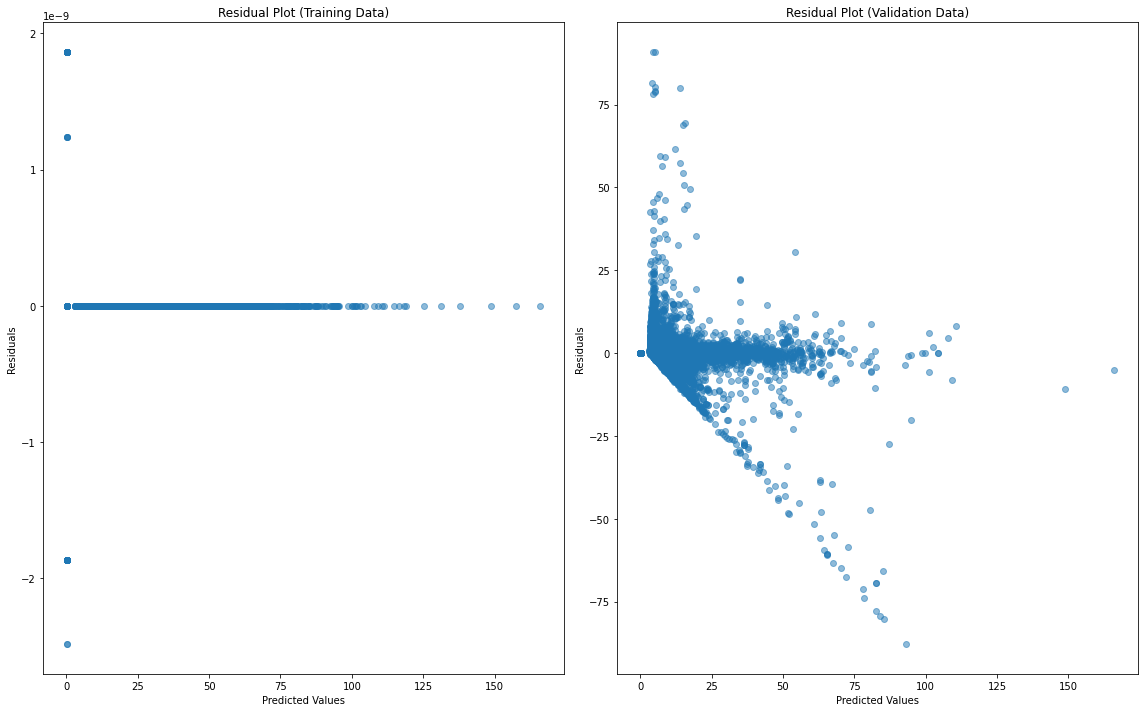

In [116]:
evaluate_model(model, X_train_encoded, y_train, X_test_encoded, y_test)

In [108]:
# Feature Importances
feature_importances = dict(zip(X_train_encoded.columns, model.feature_importances_))
sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)

[('kFLOPs', 0.5546607432470042),
 ('Precision_32', 0.19493952023292216),
 ('Input Size', 0.10564097089633581),
 ('Inputs', 0.07207310368829047),
 ('Output Size', 0.06447996116181612),
 ('Bias', 0.0061566928608970195),
 ('Precision_162', 0.0012994009606903906),
 ('Precision_161', 0.0007496069520438688)]

In [117]:
plt.figure(figsize=(20,10))
tree.plot_tree(model, filled=True, feature_names=X_train_encoded.columns, proportion=True)
plt.show()

In [119]:
model = RandomForestRegressor(random_state=0)
model.fit(X_train_encoded, y_train)
# model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

Train r2: 0.9617016716125567
Train MSE: 0.31901386094569556
Validation r2: 0.7185657221554256
Validation MSE: 2.2386806834561472


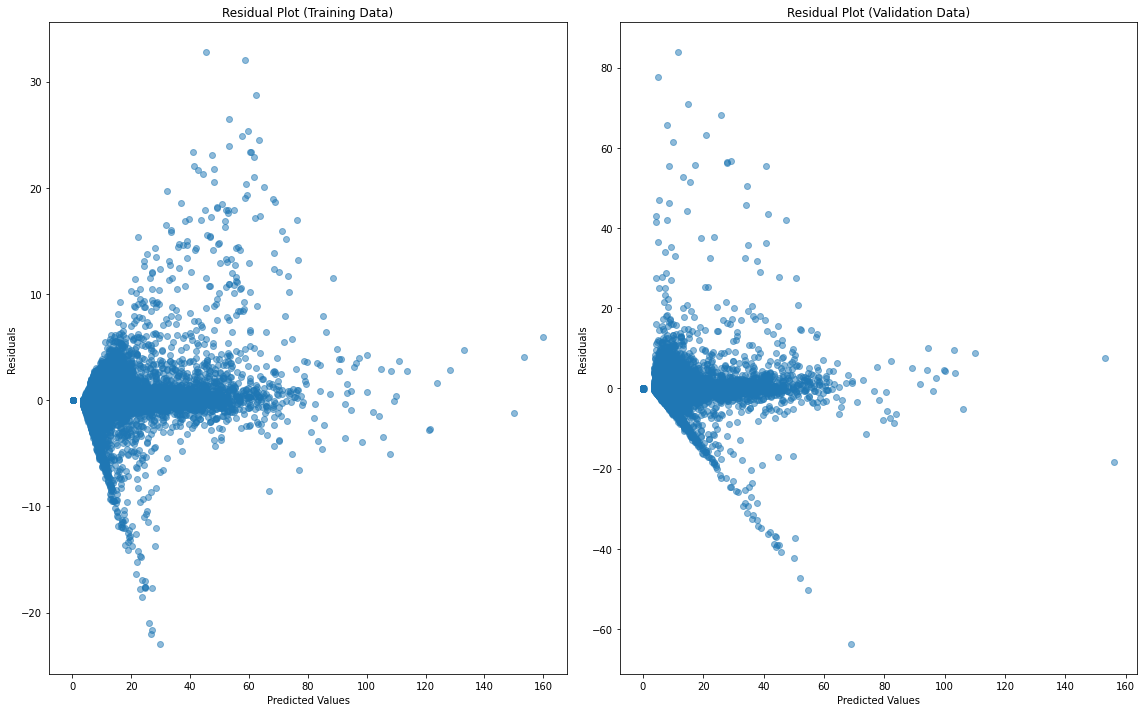

In [120]:
evaluate_model(model, X_train_encoded, y_train, X_test_encoded, y_test)

In [121]:
# Feature Importances
feature_importances = dict(zip(X_train_encoded.columns, model.feature_importances_))
sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)

[('kFLOPs', 0.5532337310068038),
 ('Precision_32', 0.19546579846683396),
 ('Input Size', 0.11221784123393455),
 ('Inputs', 0.06731804747365942),
 ('Output Size', 0.06356575667981644),
 ('Bias', 0.0061050975295446905),
 ('Precision_162', 0.0016854005109253338),
 ('Precision_161', 0.00040832709848177373)]

## Kitchen Sink

In [ ]:
categorical = ["Precision"]
numeric = list(sorted(["Inputs", "Bias", "Input Size", "Output Size", "kFLOPs"]))

X_cols = list(sorted(categorical + numeric))
y_cols = ["Latency (ms)", "Duration (usecond)"]

X, y = df[X_cols], df[y_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


to_drop = list(sorted(["Params", "Kernel Name", "Context", "Stream", "Block Size", "Grid Size", "Device", "CC", "Function Cache Configuration"])) # Kernels Launched
y_cols = ["Latency (ms)", "Duration (usecond)"]
columns = set(df.columns)
X_cols = sorted(columns - to_drop - set(y_cols))

In [ ]:
X_train_encoded = pd.get_dummies(X_train, columns=categorical)
X_test_encoded = pd.get_dummies(X_test, columns=categorical)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [ ]:
"""
TODO:

Plot input size for square matrices

One tensor, set B == A
torch.no_grad, eval() mode
Use torch.mm instead of using the module and calling inductor.

Just do this for square matrices, see what differences in the data we see.
"""